In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_full = pd.read_csv("data/source/train_data.csv")

In [3]:
# shift time to the start of the period
df_full["timestamp"] -= df_full["timestamp"].min()
# translate time to hours
df_full["timestamp"] /= 60 * 60

In [4]:
df_full.describe()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt
count,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06
mean,5.114566e+03,3.005684e+01,5.941014e+01,1.073289e+02,4.281519e+00,2.935381e+02,2.227026e+01,4.969738e+00,2.337222e-01,1.596899e-02,3.001426e+00
std,2.631255e+03,2.851339e+00,5.582277e+00,3.120410e+03,6.927234e+01,4.169500e+02,3.842956e+01,8.166667e+00,9.078254e-01,1.590046e-01,5.725451e+00
min,0.000000e+00,-4.841021e+01,-1.390007e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.989000e+03,3.028221e+01,5.992136e+01,1.700000e+01,0.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.326000e+03,3.031590e+01,5.993486e+01,3.700000e+01,1.000000e+00,1.160000e+02,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,7.316000e+03,3.035632e+01,5.995961e+01,7.400000e+01,3.000000e+00,4.010000e+02,2.500000e+01,6.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
max,9.503000e+03,1.371368e+02,6.037409e+01,8.700346e+06,1.111460e+05,2.200000e+03,4.860000e+02,2.340000e+02,9.200000e+01,3.600000e+01,1.099000e+03


In [5]:
locations = np.unique(df_full[["lon", "lat"]], axis=0)
location_to_index = {(loc[0], loc[1]): i for i, loc in enumerate(locations)}
len(locations)

7041

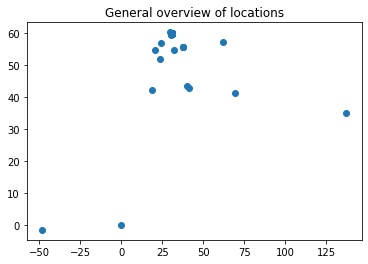

In [6]:
plt.plot(locations[:, 0], locations[:, 1], 'o')
plt.title("General overview of locations")
plt.show()

For example, let's consider St.Petersburg

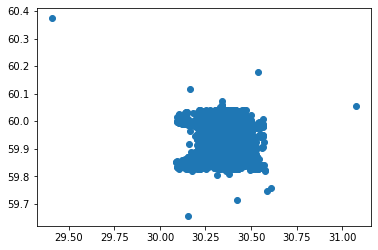

In [7]:
size = 10
x, y = 30.4, 59.9
part = locations[(locations[:, 0] <= x + size / 2) &
                 (locations[:, 0] >= x - size / 2) &
                 (locations[:, 1] <= y + size / 2) &
                 (locations[:, 1] >= y - size / 2)]
plt.plot(part[:, 0], part[:, 1], 'o')
plt.show()

Let us know, how big are other locations

[-1  0]


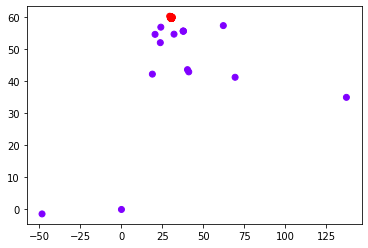

In [8]:
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm

clustering = DBSCAN(eps=2, min_samples=4)
labels = clustering.fit_predict(locations)
print(np.unique(labels))

colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
plt.scatter(locations[:, 0], locations[:, 1], color=[colors[i + 1] for i in labels])
plt.show()

We see that only St.Petersburg region has more than 3 cells. Let us investigate how much activity there is in other locations.

In [9]:
for i, label in enumerate(labels):
    if label != -1:
        continue
    x, y = locations[i]
    loc_df = df_full[(df_full["lon"] == x) & (df_full["lat"] == y)]
    part = len(loc_df) / len(df_full) * 100
    print("Location ({:8.4f}, {:8.4f}) contains {:5} messages which is {:6.3f}% of all messages".format(y, x, len(loc_df), part))


Location ( -1.3900, -48.4102) contains   107 messages which is  0.001% of all messages
Location (  0.0000,   0.0000) contains 74415 messages which is  0.873% of all messages
Location ( 42.2899,  18.8467) contains    15 messages which is  0.000% of all messages
Location ( 54.7150,  20.4861) contains     1 messages which is  0.000% of all messages
Location ( 52.1167,  23.6908) contains   335 messages which is  0.004% of all messages
Location ( 56.9590,  24.0007) contains    16 messages which is  0.000% of all messages
Location ( 54.7746,  32.0474) contains     4 messages which is  0.000% of all messages
Location ( 55.7586,  37.6214) contains    32 messages which is  0.000% of all messages
Location ( 55.7219,  37.6394) contains    21 messages which is  0.000% of all messages
Location ( 55.7080,  37.8123) contains     2 messages which is  0.000% of all messages
Location ( 43.6894,  40.2513) contains     1 messages which is  0.000% of all messages
Location ( 42.9969,  41.0216) contains   85

We will not consider these locations as they have very low activity comparing to St.Petersburg.
However, we think that it is important to consider (0, 0) location as it looks like it is a default location
for messages with unknown location.

In [10]:
df = df_full.copy()
df["label"] = [labels[location_to_index[(loc[0], loc[1])]] for loc in df_full[["lon", "lat"]].values]
df = df[df["label"] == 0].reset_index()
df["count"] = 1
df.describe()

,index,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,label,count
count,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8450632.0,8450632.0
mean,4.263627e+06,5.120060e+03,3.032078e+01,5.993631e+01,1.071372e+02,4.277259e+00,2.931261e+02,2.223388e+01,4.965741e+00,2.332640e-01,1.594520e-02,2.996399e+00,0.0,1.0
std,2.461146e+06,2.631043e+03,7.437129e-02,4.500485e-02,3.133518e+03,6.950497e+01,4.166935e+02,3.840202e+01,8.163083e+00,9.075933e-01,1.590469e-01,5.706811e+00,0.0,0.0
min,0.000000e+00,0.000000e+00,2.940635e+01,5.965693e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0
25%,2.132435e+06,2.994000e+03,3.028670e+01,5.992136e+01,1.700000e+01,0.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0
50%,4.263836e+06,5.341000e+03,3.031814e+01,5.993599e+01,3.600000e+01,1.000000e+00,1.160000e+02,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0,1.0
75%,6.394746e+06,7.327000e+03,3.035632e+01,5.995961e+01,7.400000e+01,3.000000e+00,4.000000e+02,2.500000e+01,6.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.0,1.0
max,8.526525e+06,9.503000e+03,3.107722e+01,6.037409e+01,8.700346e+06,1.111460e+05,2.200000e+03,4.860000e+02,2.340000e+02,9.200000e+01,3.600000e+01,1.099000e+03,0.0,1.0


In [11]:
df_zero = df_full[(df_full["lon"] == 0) & (df_full["lat"] == 0)].copy().reset_index()
df_zero["count"] = 1
df_zero.describe()

,index,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,count
count,7.441500e+04,74415.000000,74415.0,74415.0,74415.000000,74415.000000,74415.000000,74415.000000,74415.000000,74415.000000,74415.000000,74415.000000,74415.0
mean,4.227761e+06,4534.214984,0.0,0.0,129.023906,4.749929,342.556514,26.574185,5.445206,0.287738,0.018907,3.592340,1.0
std,2.490027e+06,2570.219089,0.0,0.0,787.128118,34.982989,443.532523,41.320451,8.559404,0.938346,0.155459,7.545354,0.0
min,2.130000e+02,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2.047896e+06,2514.000000,0.0,0.0,18.000000,0.000000,34.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,4.192361e+06,4075.000000,0.0,0.0,39.000000,1.000000,167.000000,8.000000,1.000000,0.000000,0.000000,1.000000,1.0
75%,6.422322e+06,6805.000000,0.0,0.0,81.000000,3.000000,481.000000,34.000000,7.000000,0.000000,0.000000,4.000000,1.0
max,8.525938e+06,9503.000000,0.0,0.0,82782.000000,4588.000000,2200.000000,386.000000,59.000000,30.000000,7.000000,1096.000000,1.0


In [12]:
df = df.groupby(["lon", "lat", "timestamp"]).agg({
    "count":"sum",
    "likescount": np.mean,
    "commentscount": np.mean,
    "symbols_cnt": np.mean,
    "words_cnt": np.mean,
    "hashtags_cnt": np.mean,
    "mentions_cnt": np.mean,
    "links_cnt": np.mean,
    "emoji_cnt": np.mean,
}).reset_index()

In [13]:
max_time = int(df["timestamp"].max())
max_time

9503

Let's see come examples of time series, sample 5 polygons

In [14]:
def plot_time_series(data, title):
    counts = [0] * (max_time + 1)
    times = list(range(max_time + 1))
    for t, c in data[["timestamp", "count"]].values:
        counts[int(t)] = c
    plt.figure(figsize=(40, 3))
    plt.plot(times, counts)
    plt.title(title)
    plt.show()

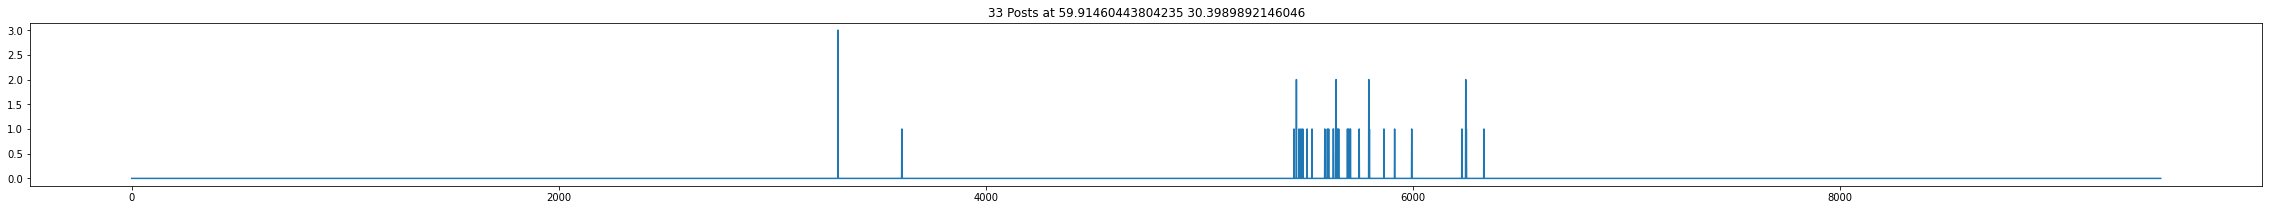

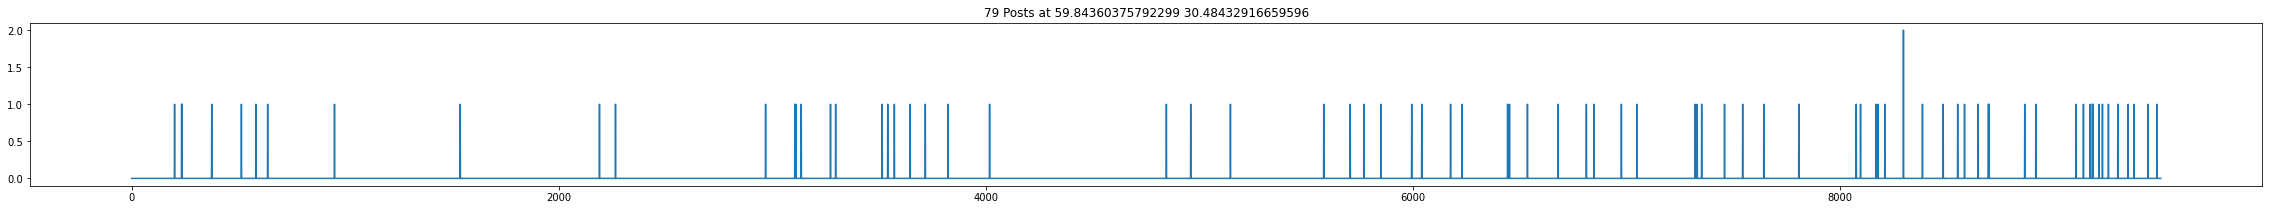

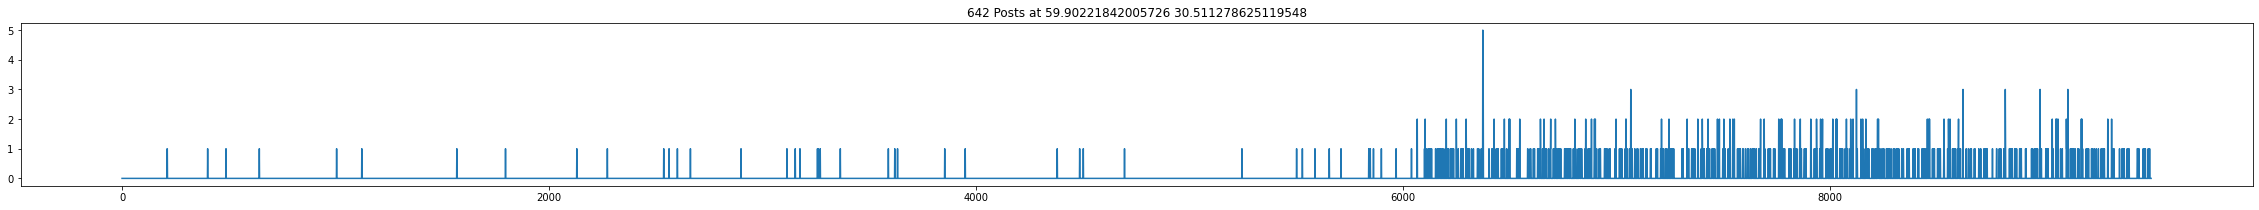

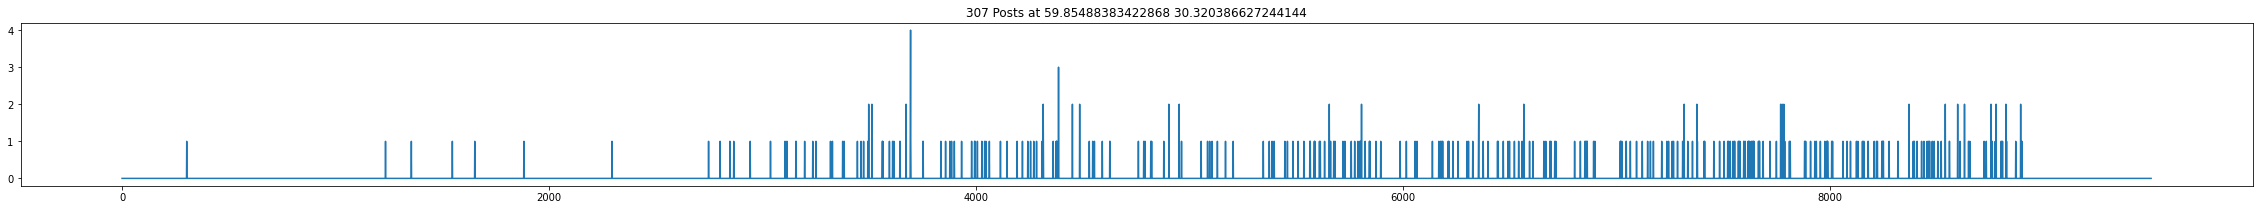

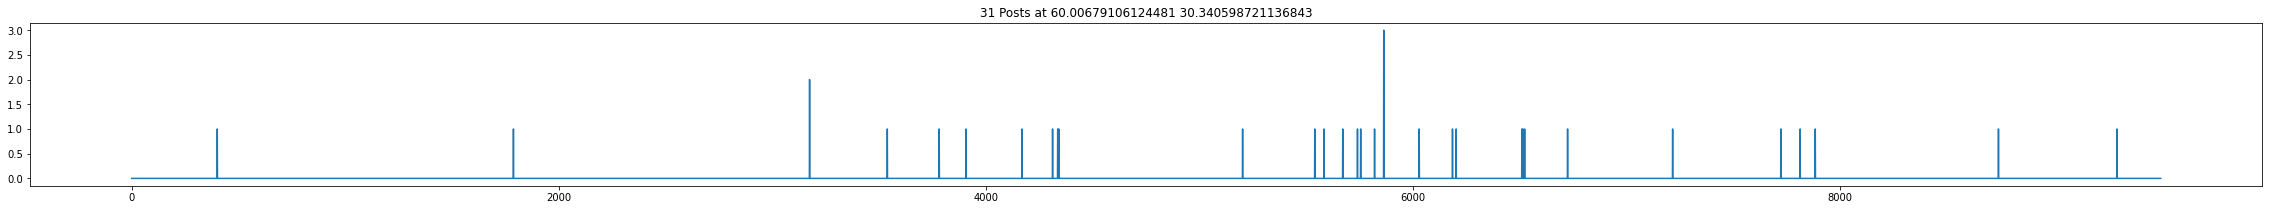

In [15]:
locations = np.unique(df[["lon", "lat"]], axis=0)
np.random.seed(42)
random_sample = np.random.choice(list(range(len(locations))), 5, replace=False)

for loc in [locations[i] for i in random_sample]:
    loc_df = df[(df["lon"] == loc[0]) & (df["lat"] == loc[1])]
    plot_time_series(loc_df, "{} Posts at {} {}".format(len(loc_df), loc[1], loc[0]))

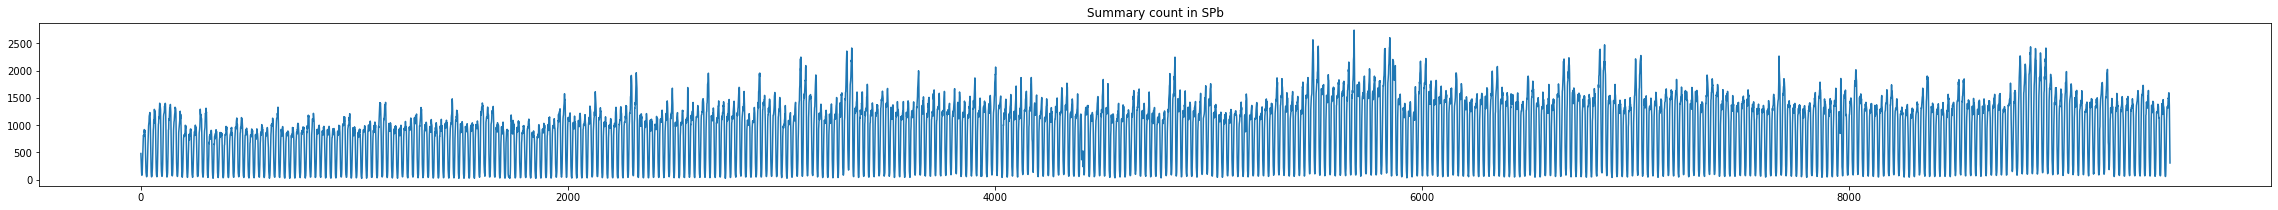

In [18]:
df_avg = df.groupby("timestamp").agg({"count": "sum"}).reset_index()
plot_time_series(df_avg, "Summary count in SPb")